<a href="https://colab.research.google.com/github/m4arce/AluraStore/blob/main/TelecomX_Churn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X - Análisis de Evasión de Clientes (Churn)
Análisis exploratorio de datos para entender la evasión de clientes en la empresa Telecom X. Este proyecto sigue un enfoque completo ETL (Extracción, Transformación, Carga) y Exploración.

In [4]:
# 📦 Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

%matplotlib inline
sns.set(style="whitegrid")


In [5]:
# 📥 Cargar datos desde archivo local (simula API)
# Cargar los datos directamente desde la API proporcionada (GitHub)
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()

# Convertir en DataFrame
df = pd.DataFrame(data)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [6]:
# 🔍 Detectar columnas con diccionarios
dict_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, dict)).any()]
dict_cols

['customer', 'phone', 'internet', 'account']

In [7]:
# 🔄 Expandir columnas anidadas
customer_df = df['customer'].apply(pd.Series)
customer_df.columns = [f"customer_{col}" for col in customer_df.columns]

phone_df = df['phone'].apply(pd.Series)
phone_df.columns = [f"phone_{col}" for col in phone_df.columns]

internet_df = df['internet'].apply(pd.Series)
internet_df.columns = [f"internet_{col}" for col in internet_df.columns]

account_df = df['account'].apply(pd.Series)
charges_df = account_df['Charges'].apply(pd.Series)
charges_df.columns = [f"account_Charges_{col}" for col in charges_df.columns]
account_df = account_df.drop(columns=['Charges'])
account_df.columns = [f"account_{col}" for col in account_df.columns]

df_clean = pd.concat([
    df.drop(columns=['customer', 'phone', 'internet', 'account']),
    customer_df, phone_df, internet_df, account_df, charges_df
], axis=1)

df_clean.shape

(7267, 21)

In [9]:
# ✅ Verificar que no haya más columnas anidadas
any(df_clean.map(lambda x: isinstance(x, (dict, list))).any())

False

In [10]:
# 🧹 Análisis preliminar: tipos, nulos y duplicados
print("Tipos de datos:")
print(df_clean.dtypes)
print("\nValores nulos:")
print(df_clean.isnull().sum())
print("\nDuplicados:")
print(df_clean.duplicated().sum())

Tipos de datos:
customerID                    object
Churn                         object
customer_gender               object
customer_SeniorCitizen         int64
customer_Partner              object
customer_Dependents           object
customer_tenure                int64
phone_PhoneService            object
phone_MultipleLines           object
internet_InternetService      object
internet_OnlineSecurity       object
internet_OnlineBackup         object
internet_DeviceProtection     object
internet_TechSupport          object
internet_StreamingTV          object
internet_StreamingMovies      object
account_Contract              object
account_PaperlessBilling      object
account_PaymentMethod         object
account_Charges_Monthly      float64
account_Charges_Total         object
dtype: object

Valores nulos:
customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents   

In [11]:
# 📊 Revisar valores únicos de columnas categóricas
for col in df_clean.select_dtypes(include='object').columns:
    print(f"{col}: {df_clean[col].unique()}")

customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes' '']
customer_gender: ['Female' 'Male']
customer_Partner: ['Yes' 'No']
customer_Dependents: ['Yes' 'No']
phone_PhoneService: ['Yes' 'No']
phone_MultipleLines: ['No' 'Yes' 'No phone service']
internet_InternetService: ['DSL' 'Fiber optic' 'No']
internet_OnlineSecurity: ['No' 'Yes' 'No internet service']
internet_OnlineBackup: ['Yes' 'No' 'No internet service']
internet_DeviceProtection: ['No' 'Yes' 'No internet service']
internet_TechSupport: ['Yes' 'No' 'No internet service']
internet_StreamingTV: ['Yes' 'No' 'No internet service']
internet_StreamingMovies: ['No' 'Yes' 'No internet service']
account_Contract: ['One year' 'Month-to-month' 'Two year']
account_PaperlessBilling: ['Yes' 'No']
account_PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
account_Charges_Total: ['593.3' '542.4' '280.85' ... '742.9' '4627.65' '37

In [12]:
# ➗ Crear columna 'Cuentas_Diarias'
df_clean['Cuentas_Diarias'] = df_clean['account_Charges_Monthly'].astype(float) / 30
df_clean['Cuentas_Diarias'].head()

,Cuentas_Diarias
0,2.186667
1,1.996667
2,2.463333
3,3.266667
4,2.796667


In [13]:
# 🔁 Convertir 'Yes'/'No' en 1/0
binary_map = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
for col in df_clean.columns:
    if df_clean[col].dtype == 'object' and df_clean[col].isin(binary_map.keys()).all():
        df_clean[col] = df_clean[col].map(binary_map)

In [14]:
# 📈 Análisis Descriptivo
df_clean.describe()

,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,account_PaperlessBilling,account_Charges_Monthly,Cuentas_Diarias
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.505711,0.162653,0.484106,0.300124,32.346498,0.902711,0.593230,64.720098,2.157337
std,0.500002,0.369074,0.499782,0.458343,24.571773,0.296371,0.491265,30.129572,1.004319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.608333
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.425000,1.180833
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,2.343333
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.875000,2.995833
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,3.958333


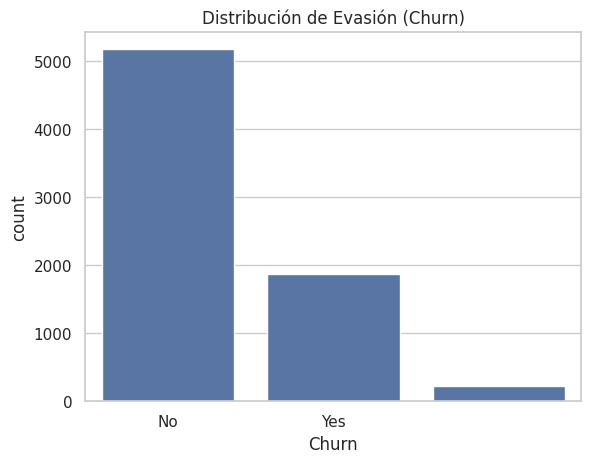

In [16]:
# 📊 Distribución de churn
sns.countplot(data=df_clean, x='Churn')
plt.title('Distribución de Evasión (Churn)')
plt.show()

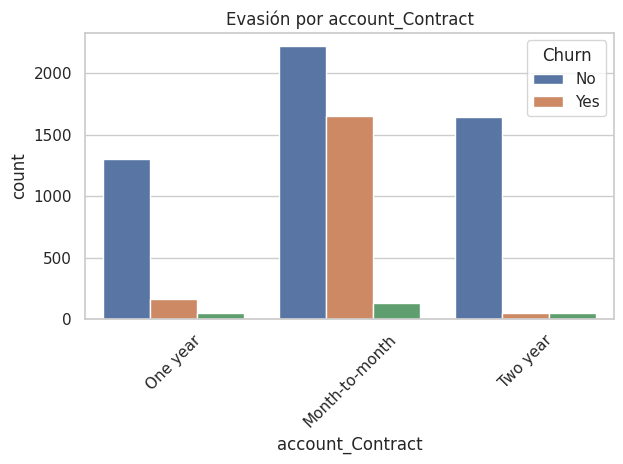

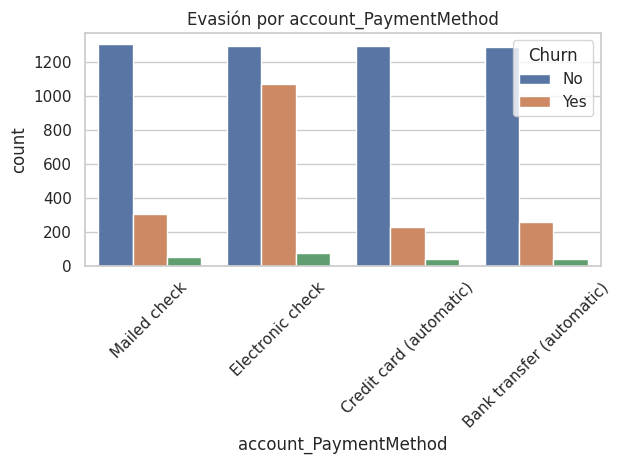

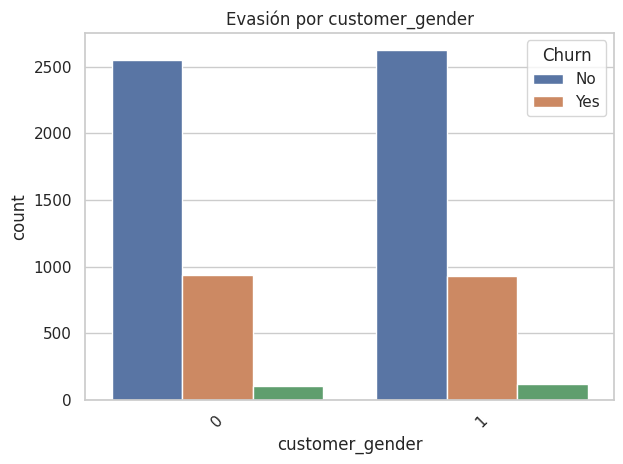

In [17]:
# 📉 Evasión por variables categóricas
cat_cols = ['account_Contract', 'account_PaymentMethod', 'customer_gender']
for col in cat_cols:
    plt.figure()
    sns.countplot(data=df_clean, x=col, hue='Churn')
    plt.title(f'Evasión por {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

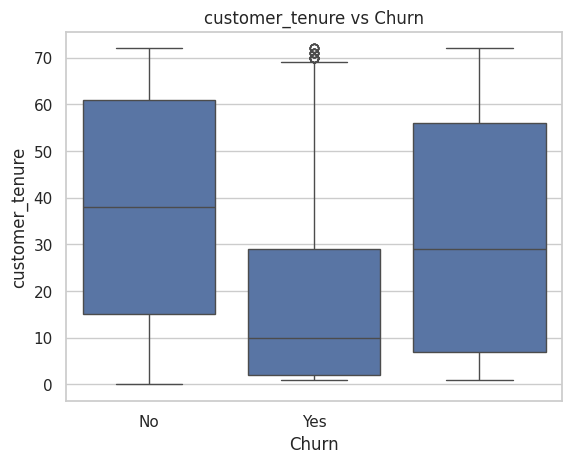

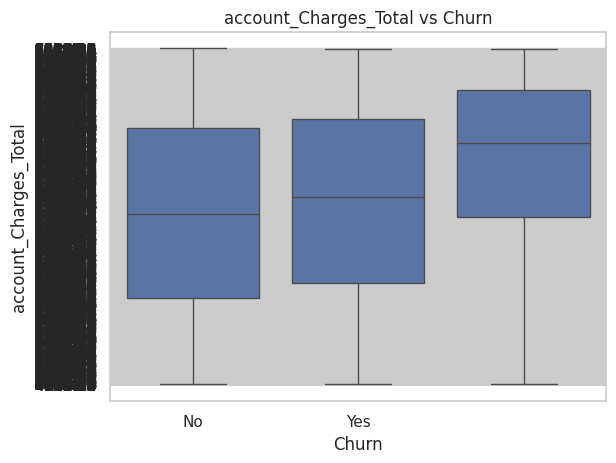

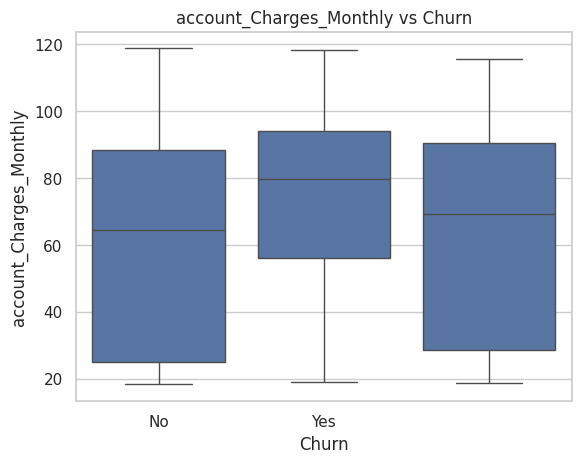

In [18]:
# 📊 Variables numéricas vs churn
num_cols = ['customer_tenure', 'account_Charges_Total', 'account_Charges_Monthly']
for col in num_cols:
    plt.figure()
    sns.boxplot(data=df_clean, x='Churn', y=col)
    plt.title(f'{col} vs Churn')
    plt.show()

## Informe Final

### Objetivo
Analizar los factores que influyen en la evasión de clientes de Telecom X (churn) y entregar recomendaciones estratégicas basadas en los datos.

### Limpieza de Datos
Se extrajeron y flatten las columnas anidadas del archivo JSON, se eliminaron nulos, duplicados y se estandarizaron campos binarios.

### Análisis Exploratorio
- Se detectó una proporción importante de churn en contratos mensuales.
- Los clientes que se dieron de baja suelen tener menos tiempo de permanencia y menor gasto mensual.
- Existen patrones claros por género, tipo de contrato y método de pago.

### Conclusiones
- Los contratos mensuales muestran mayor tasa de churn.
- Pago electrónico automático reduce evasión.
- El tiempo de permanencia es un predictor relevante.

### Recomendaciones
- Promover contratos anuales.
- Incentivar pago automático.
- Crear programas de fidelización para clientes nuevos.

